## 1. 분석환경 구축 

### 1.1 Colab 구글 드라이브 연동

In [1]:
# 구글 Colaboratory 를 사용하기 위해 구글 계정으로 로그인합니다. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 라이브러리 임포트

In [2]:
import pandas as pd
import numpy as np
import time 
import datetime

# One Hot Encoding 라이브러리
from sklearn.preprocessing import OneHotEncoder

# EDA 용 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as font
import seaborn as sns

# 모델링을 위한 라이브러리
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Data Augmentation 을 위한 라이브러리
from imblearn.over_sampling import SMOTE

### 1.3. 랜덤시드 고정

In [3]:
# 랜덤시드 고정
RANDOM_SEED = 0

## 2. 데이터 로딩

### 2.1. 데이터 파일 열기

In [7]:
# 구글 드라이브 내 데이터가 위치한 경로를 설정합니다.
path = '/content/drive/MyDrive/YDS/AIConnet_YDS_1/RS_restaurant/'

# 학습용 데이터 파일
data = pd.read_csv(f'{path}DATA/Train.csv', encoding='utf-8')

# 평가용 데이터 파일
test = pd.read_csv(f'{path}DATA/Test.csv', encoding='utf-8')

# 제출용 파일
submit = pd.read_csv(f'{path}DATA/Sample_Submission.csv', encoding='utf-8')

### 2.2. 데이터 확인

In [8]:
data.shape

(8307, 19)

In [9]:
data.head()

,Unnamed: 0,식당ID,식당이름,주소,메뉴,영업시간,평점,AI산출점수,지역,좋아요 수,주요품목,방문목적,시설,리뷰_작성자,총평,맛평점,가격평점,서비스평점,텍스트
0,0,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",NaN,24569,1.0,3.0,1.0,1.0,세상살다 이렇게 불친절 끝판왕인 식당은 처음보네요!!\n\n\n불친절 풀코스 체험기...
1,2,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",NaN,71433,1.0,5.0,3.0,1.0,다시는 안감\n\n(음식은 맛있음)
2,3,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",NaN,98352,4.0,3.0,5.0,3.0,집밥을 향해 돌진하는 방배 마을 회관 같은 식당. 언제든 들려 한 끼 푸짐한 밥을 ...
3,4,82,10 꼬르소꼬모 카페,서울특별시 강남구 압구정로 416,"[{'menu': '후루티 디 마레 카펠리니', 'price': '49000'}, ...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.3,53,청담,77.0,"카페,밀크티빙수","데이트,소개팅","발렛가능,발렛",62074,4.0,5.0,3.0,5.0,이색적인 인테리어가 특유의 고급스러운 분위기를 살려주는 카페 겸 식당. 테이블 마다...
4,5,140,101번지 남산돈까스,서울특별시 중구 소파로 101(남산동2가),"[{'menu': '남산왕돈까스', 'price': '10500'}, {'menu'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.4,58,남산,137.0,"돈까스,왕돈까스","데이트,가족외식","발렛,셀프바,지역화폐",95119,5.0,5.0,5.0,3.0,진짜 큰 돈까스!!왕 크고 얇아서 경양식 돈까스로 딱!!! 스프도 같이 나오고 고추...


In [10]:
test.shape

(711, 16)

In [11]:
test.head()

,Unnamed: 0,식당ID,식당이름,주소,메뉴,영업시간,평점,AI산출점수,지역,좋아요 수,주요품목,방문목적,시설,리뷰_작성자,총평,Answer_ID
0,0,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",NaN,94354,0,94354_38
1,1,370,128판,서울특별시 종로구 동숭4길 14,"[{'menu': '마레', 'price': '12000'}, {'menu': '풍...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.5,52,혜화,18.0,"파스타,풍기리조또","데이트,기념일",예약필수,63420,0,63420_370
2,2,2155,37.5,서울특별시 서초구 서래로7길 16,"[{'menu': '정통 아메리칸 브런치', 'price': '17900'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.2,38,서래마을,16.0,"브런치카페,브런치","데이트,모임",발렛,81264,0,81264_2155
3,3,2513,4브라더스,서울특별시 강남구 논현로28길 40,"[{'menu': '안심 쌀국수', 'price': '11500'}, {'menu'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.3,68,도곡,164.0,"쌀국수,월남쌈","가족외식,모임장소",발렛,58332,0,58332_2513
4,4,8415,e모네 춘천닭갈비,서울특별시 서초구 반포대로22길 89,"[{'menu': '닭갈비', 'price': '10000'}, {'menu': '...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.2,49,교대역,15.0,"닭갈비,닭갈비덮밥","식사모임,모임",NaN,80349,0,80349_8415


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8307 entries, 0 to 8306
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8307 non-null   int64  
 1   식당ID        8307 non-null   int64  
 2   식당이름        8307 non-null   object 
 3   주소          8307 non-null   object 
 4   메뉴          8307 non-null   object 
 5   영업시간        8307 non-null   object 
 6   평점          8307 non-null   float64
 7   AI산출점수      8307 non-null   int64  
 8   지역          8307 non-null   object 
 9   좋아요 수       8177 non-null   float64
 10  주요품목        8301 non-null   object 
 11  방문목적        8233 non-null   object 
 12  시설          5560 non-null   object 
 13  리뷰_작성자      8307 non-null   int64  
 14  총평          8307 non-null   float64
 15  맛평점         8307 non-null   float64
 16  가격평점        8307 non-null   float64
 17  서비스평점       8307 non-null   float64
 18  텍스트         8307 non-null   object 
dtypes: float64(6), int64(4), ob

식당ID, 리뷰_작성자, 주요품목, 지역 항목에 대해서 범주형 데이터로 간주하고 각 데이터의 가짓수를 파악.

In [13]:
print(len(data['식당ID'].unique()))
print(len(data['리뷰_작성자'].unique()))
print(len(data['주요품목'].unique()))
print(len(data['지역'].unique()))

2928
1709
2184
224


이 중에서 의미가 있다고 판단되는 데이터의 활용 가능성을 파악.

In [ ]:
print(len(set(data['식당ID'])))
print(len(set(test['식당ID'])))
print(len(set(test['식당ID']) - set(data['식당ID'])))

2928
625
61


식당ID의 경우, 학습데이터에 존재하지 않는 데이터가 평가데이터에 존재함을 확인하였음. 학습에 사용하지 않는 것이 좋겠다고 판단됨.<br>
같은 논리로 식당의 고유한 정보 '위치', '주소', '영업시간', '메뉴' 등도 사용하지 않기로 함.

In [ ]:
print(len(set(data['리뷰_작성자'])))
print(len(set(test['리뷰_작성자'])))
print(len(set(test['리뷰_작성자']) - set(data['리뷰_작성자'])))

1709
399
0


리뷰_작성자의 경우는 학습데이터에 존재하는 데이터만 평가용데이터에 존재함을 확인. 리뷰_작성자 데이터는 학습에 이용할 수 있다고 판단됨.

### 2.3. 데이터 전처리

필요한 컬럼만 남기고 결측치를 처리함.

In [14]:
def preprocessing(df):
  selected_features = ['리뷰_작성자', '평점', 'AI산출점수', '좋아요 수', '총평']
  df = df[selected_features]
  # 결측치 처리
  df = df.fillna(0)
  return df

In [15]:
train_df = preprocessing(data)
test_df = preprocessing(test)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8307 entries, 0 to 8306
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   리뷰_작성자  8307 non-null   int64  
 1   평점      8307 non-null   float64
 2   AI산출점수  8307 non-null   int64  
 3   좋아요 수   8307 non-null   float64
 4   총평      8307 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 324.6 KB


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   리뷰_작성자  711 non-null    int64  
 1   평점      711 non-null    float64
 2   AI산출점수  711 non-null    int64  
 3   좋아요 수   711 non-null    float64
 4   총평      711 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 27.9 KB


### 2.4. One Hot Encoding 적용
범주형 데이터인 '리뷰_작성자'에 대해서 One Hot Encoding 적용함.

In [18]:
# 인코더 생성
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_df[['리뷰_작성자']])

# Train Data 에 대해서 인코딩 처리를 함.
ohe_encoded = ohe.transform(train_df[['리뷰_작성자']])
ohe_df = pd.DataFrame(ohe_encoded)

# 인코딩 결과를 기존 Train 데이터에 붙임.
train_df = pd.concat([train_df, ohe_df], axis=1)
train_df

,리뷰_작성자,평점,AI산출점수,좋아요 수,총평,0,1,2,3,4,...,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708
0,24569,3.6,42,16.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,71433,3.6,42,16.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,98352,3.6,42,16.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62074,4.3,53,77.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,95119,3.4,58,137.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8302,26086,3.5,42,12.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8303,39132,3.5,42,12.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8304,90612,4.6,45,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8305,12464,4.6,45,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Test Data 에도 동일한 처리를 함.
ohe_encoded = ohe.transform(test_df[['리뷰_작성자']])
ohe_df = pd.DataFrame(ohe_encoded)

# 인코딩 결과를 기존 Test 데이터에 붙임.
test_df = pd.concat([test_df, ohe_df], axis=1)
test_df

,리뷰_작성자,평점,AI산출점수,좋아요 수,총평,0,1,2,3,4,...,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708
0,94354,3.6,42,16.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63420,4.5,52,18.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81264,3.2,38,16.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58332,4.3,68,164.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80349,4.2,49,15.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,93880,4.4,50,1.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707,25201,4.6,56,2.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
708,61185,4.7,49,2.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,17405,3.7,41,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Train 데이터와 Test 데이터에서 '총평' 과 '리뷰_작성자' 는 삭제함.
features = [col for col in train_df.columns if col != '총평' and col != '리뷰_작성자']
X_train_raw = train_df[features]
X_test_raw = test_df[features]

# Train 데이터에서 '총평'만 떼네어서 y_train_raw 생성.
y_train_raw = train_df['총평']

In [21]:
print(X_train_raw.shape)
print(y_train_raw.shape)
print(X_test_raw.shape)

(8307, 1712)
(8307,)
(711, 1712)


In [22]:
X_train_raw

,평점,AI산출점수,좋아요 수,0,1,2,3,4,5,6,...,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708
0,3.6,42,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.6,42,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.6,42,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.3,53,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.4,58,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8302,3.5,42,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8303,3.5,42,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8304,4.6,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8305,4.6,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y_train_raw

0       1.0
1       1.0
2       4.0
3       4.0
4       5.0
       ... 
8302    3.0
8303    3.0
8304    5.0
8305    5.0
8306    5.0
Name: 총평, Length: 8307, dtype: float64

In [24]:
X_test_raw

,평점,AI산출점수,좋아요 수,0,1,2,3,4,5,6,...,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708
0,3.6,42,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.5,52,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.2,38,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.3,68,164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.2,49,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,4.4,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707,4.6,56,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
708,4.7,49,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,3.7,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. EDA



### 3.1. EDA용 데이터프레임 생성

In [ ]:
time_2 = time.time()

In [ ]:
eda_df = data.copy() # 오리지널 파일에서 EDA 용 데이터프레임 별도 생성함.

### 3.2. 데이터 분포 확인

##### 3.2.1. '총평' 데이터가 얼마나 균등하게 분포하는지 확인.

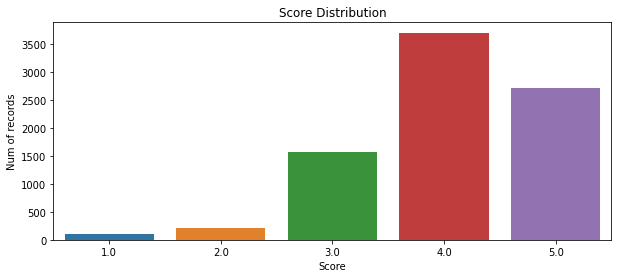

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.countplot(x='총평', data=eda_df)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Num of records')
plt.show()

데이터의 불균형이 매우 심함.
Data Augmentation 시도할 필요 있다고 판단되었음. (10/20)<br>
--> Data Augmentation 적용해 봤더니 모델의 성능이 낮아져서 최종 제출 모델에서는 제외하였음. (10/21)

##### 3.2.2. '총평' 데이터와 '좋아요 수'의 상관관계 확인

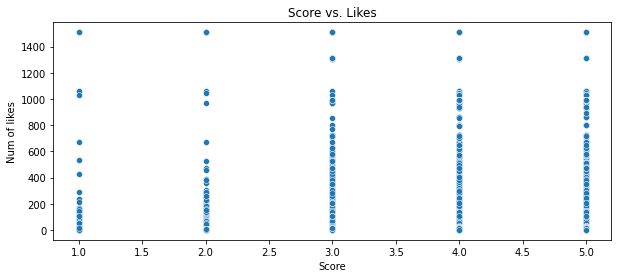

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.scatterplot(x='총평', y='좋아요 수', data=eda_df)
plt.title('Score vs. Likes')
plt.xlabel('Score')
plt.ylabel('Num of likes')
plt.show()

'총평' 점수가 1인데도 '좋아요' 가 1400 이상인 경우도 많고,<br>
'좋아요' 가 거의 없는 경우에도 '총평'이 1~5에 다양하게 분포되어 있음을 확인.<br>
'좋아요' 가 1400이 넘는 경우에 대해서 분석이 필요하다고 생각됨.

##### 3.2.3. '좋아요' 수가 1400이 넘는 식당에 대한 상세 데이터 확인.

In [ ]:
excellent = eda_df.loc[eda_df['좋아요 수'] > 1400]
print(excellent)

      Unnamed: 0    식당ID  식당이름                       주소  \
2209        2392  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2210        2393  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2211        2394  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2212        2395  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2213        2396  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
...          ...     ...   ...                      ...   
2269        2453  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2270        2454  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2271        2455  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2272        2456  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   
2273        2457  146141  명동교자  서울특별시 중구 명동10길 29(명동2가)   

                                                     메뉴  \
2209  [{'menu': '칼국수', 'price': '10000'}, {'menu': '...   
2210  [{'menu': '칼국수', 'price': '10000'}, {'menu': '...   
2211  [{'menu': '칼국수', 'price': '10000'}, {'menu': '...   
2212  [{'menu': '칼국수', 'price': '10000'}, {'menu': '...

In [ ]:
print(excellent['식당ID'].unique())
print(excellent['AI산출점수'].mean())
print(excellent['평점'].mean())
print(excellent['총평'].mean())
print(len(excellent))

[146141]
100.0
4.2
4.061538461538461
65


가장 '좋아요' 가 많은 식당은 '명동교자' 였음. 이 식당의 AI산출점수는 평균 100점인데, 실제 총평의 평균과는 차이가 좀 있음을 확인 함. '총평' 과 '평점'의 차이는 크지 않았음.

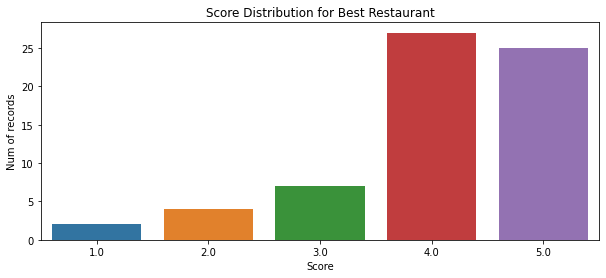

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.countplot(x='총평', data=excellent)
plt.title('Score Distribution for Best Restaurant')
plt.xlabel('Score')
plt.ylabel('Num of records')
plt.show()

명동교자의 경우, AI산출점수 평균 100점, 좋아요 1400건 이상인데도 불구하고, '총평'을 1점을 준 사람이 있고, 2점을 준 사람도 있음.

개인의 성향에 따른 식당평가가 이루어지는 것은 아닌지도 고려해 보아야 함.

##### 3.2.4. '총평'과 'AI산출점수' 와의 관계 확인

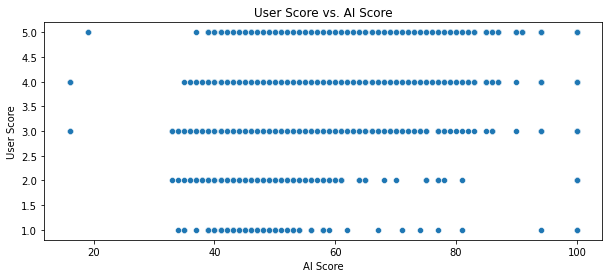

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.scatterplot(x='AI산출점수', y='총평', data=eda_df)
plt.title('User Score vs. AI Score')
plt.xlabel('AI Score')
plt.ylabel('User Score')
plt.show()

AI산출점수 30이하인데도 '총평'은 3, 4, 5점인 경우 확인됨.<br>
그 반대로 AI산출점수 90이상(심지어 100)인 경우에도 '총평'이 1, 2, 3, 4, 5로 다양하게 나타남을 확인함.

이런 데이터를 다루는 방법을 2가지로 생각해 볼 수 있음.
1. 'AI산출점수'와는 다르게, '총평'은 사람이 평가하기 때문에 평가자의 '호불호'에 의해서 평가될 가능성이 높다는 의미이기도 함. --> 그대로 둔다.
2. 'AI산출점수' 가 너무 낮거나 너무 높은 경우는 outlier 로 간주하고 데이터를 재가공한다.

3.2.5. 'AI산출점수' outlier 확인

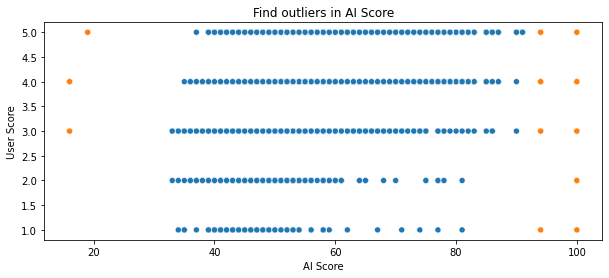

In [ ]:
outlier_df = eda_df.copy()

def outlier(x):
  if x < 30 or x > 91:
    return 'Y'
  else:
    return 'N'

fig = plt.figure(figsize=(10, 4))
outlier_df['AI산출점수_outlier'] = outlier_df['AI산출점수'].apply(outlier)
sns.scatterplot(x='AI산출점수', y='총평', hue='AI산출점수_outlier', data = outlier_df, legend=False)
plt.title('Find outliers in AI Score')
plt.xlabel('AI Score')
plt.ylabel('User Score')
plt.show()

#### 3.2.5. 'AI산출점수' 와 '평점' 의 관계 확인

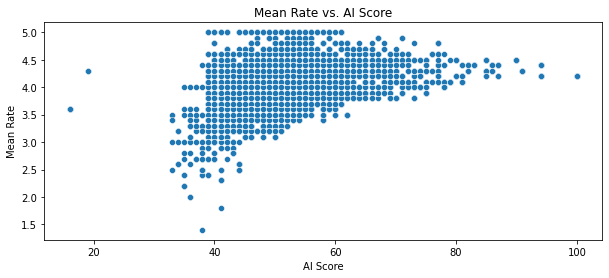

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.scatterplot(x='AI산출점수', y='평점', data=eda_df)
plt.title('Mean Rate vs. AI Score')
plt.xlabel('AI Score')
plt.ylabel('Mean Rate')
plt.show()

'AI산출점수' 와 '평점' 사이의 상관관계가 있음을 확인함. 두 값의 상관관계가 100%은 아니므로 학습에는 둘 다를 적용해 볼 가치가 있음.

#### 3.2.6. '총평' 과 '평점'의 관계 확인

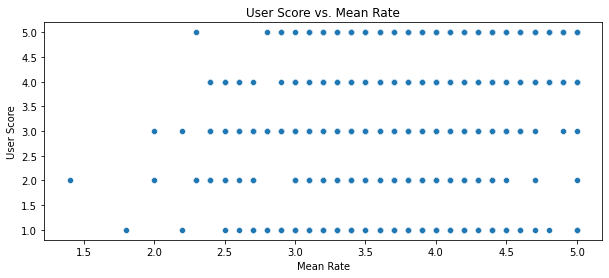

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.scatterplot(x='평점', y='총평', data=eda_df)
plt.title('User Score vs. Mean Rate')
plt.xlabel('Mean Rate')
plt.ylabel('User Score')
plt.show()

'총평' 과 '평점' 에서 특별한 상관관계 파악되지 않았음. 단순 '평점' 만으로는 '총평'의 예측이 쉽지 않겠다고 판단됨.

#### 3.2.7. '리뷰_작성자' 정보가 '총평'에 미치는 영향 확인

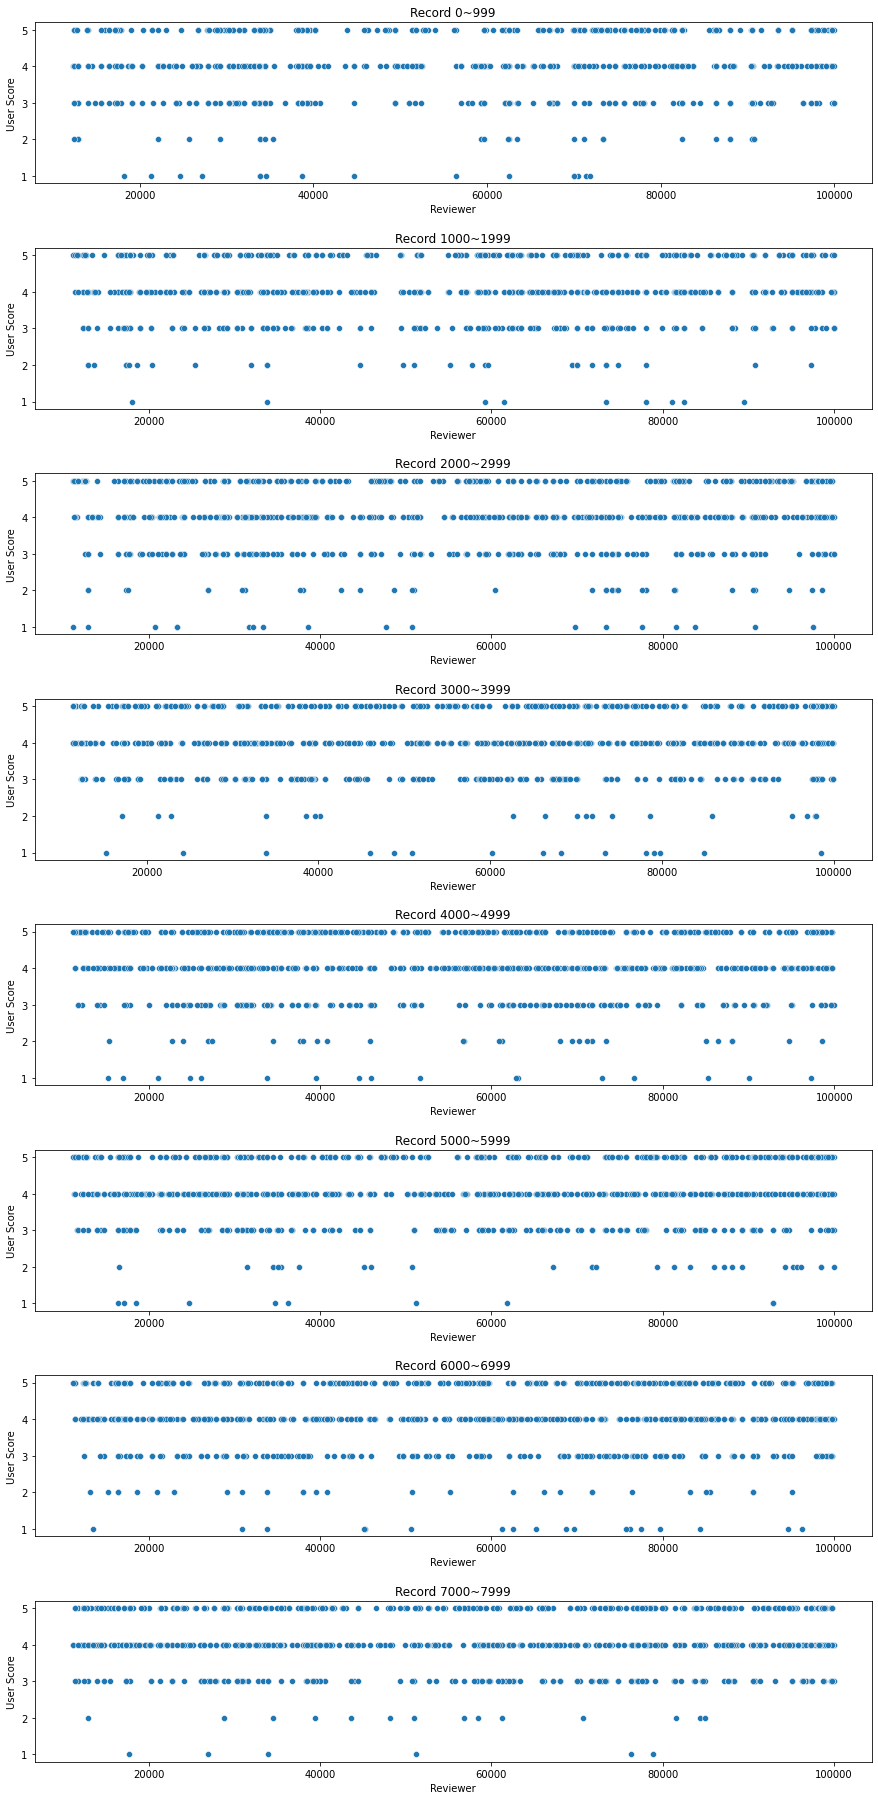

In [ ]:
NUM_ROWS = 8
fig, axes = plt.subplots(nrows=NUM_ROWS, ncols=1, sharey=True, figsize=(15,4*NUM_ROWS))
fig.subplots_adjust(hspace=.4, wspace=.1)

for i in range(NUM_ROWS):
  sns.scatterplot(x='리뷰_작성자', y='총평', data=eda_df[i*1000:(i+1)*1000-1], ax=axes[i])
  axes[i].set_title(f'Record {i*1000}~{(i+1)*1000-1}')
  axes[i].set_xlabel('Reviewer')
  axes[i].set_ylabel('User Score')

plt.show()

'리뷰_작성자' 별로 '총평'을 주는 방식이 제각각인 것을 확인.

'총평' 의 분포가 상당히 다르다는 것을 이미 확인을 하였고, 낮은 점수(1점 혹은 2점)는 전체 데이터의 3.92%에 불과함.<br>
따라서, 낮은 점수를 주는 리뷰어는 어떤 사람인지 확인이 필요함.

In [ ]:
for i in range(1, 6):
  print(f'{i}점을 준 리뷰의 수 : {[y_train_raw == i][0].sum()}')
print(f'전체 리뷰의 수: {len(y_train_raw)}')

1점을 준 리뷰의 수 : 111
2점을 준 리뷰의 수 : 215
3점을 준 리뷰의 수 : 1572
4점을 준 리뷰의 수 : 3697
5점을 준 리뷰의 수 : 2712
전체 리뷰의 수: 8307


In [ ]:
score_df = eda_df[['총평', '리뷰_작성자']]
score1_df = score_df[score_df['총평'] == 1]
score2_df = score_df[score_df['총평'] == 2]

n_t = len(score_df['리뷰_작성자'].unique())
n_1 = len(score1_df['리뷰_작성자'].unique())
n_2 = len(score2_df['리뷰_작성자'].unique())
print(f"전체 리뷰어의 수: {n_t}")
print(f"1점을 준 리뷰어의 수: {n_1}, 비율: {round(n_1*100/n_t, 2)}%")
print(f"2점을 준 리뷰어의 수: {n_2}, 비율: {round(n_2*100/n_t, 2)}%")

전체 리뷰어의 수: 1709
1점을 준 리뷰어의 수: 97, 비율: 5.68%
2점을 준 리뷰어의 수: 138, 비율: 8.07%


#### 3.2.8. 혹시 평점 테러 '빌런'이 존재하는 것은 아닐까? 확인.

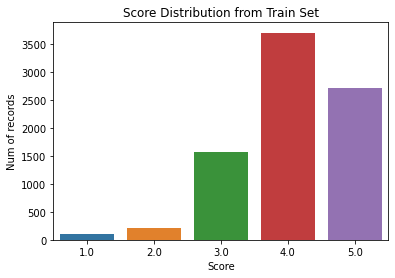

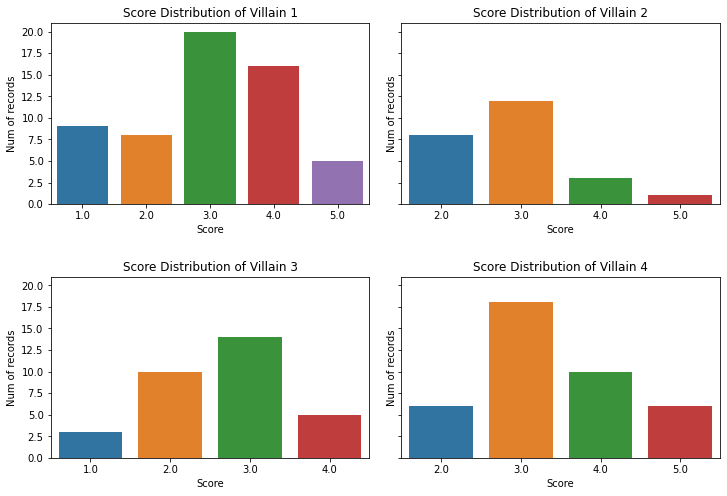

In [ ]:
# 전체 Train Set 에서 추출한 '총평' 데이터의 분포
fig = plt.figure(figsize=(6, 4))
sns.countplot(x='총평', data=score_df)
plt.title('Score Distribution from Train Set')
plt.xlabel('Score')
plt.ylabel('Num of records')
plt.show()

# '빌런' 을 추려내어 데이터의 분포를 비교해 보자.
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12,4*2))
fig.subplots_adjust(hspace=.4, wspace=.1)

score_v1_df = score_df[score_df['리뷰_작성자'] == 33874]
score_v2_df = score_df[score_df['리뷰_작성자'] == 71792]
score_v3_df = score_df[score_df['리뷰_작성자'] == 73322]
score_v4_df = score_df[score_df['리뷰_작성자'] == 88029]
#score_v5_df = score_df[score_df['리뷰_작성자'] == 90565]
#score_v6_df = score_df[score_df['리뷰_작성자'] == 90770]

sns.countplot(x='총평', data=score_v1_df, ax=axes[0][0])
axes[0][0].set_title('Score Distribution of Villain 1')
axes[0][0].set_xlabel('Score')
axes[0][0].set_ylabel('Num of records')

sns.countplot(x='총평', data=score_v2_df, ax=axes[0][1])
axes[0][1].set_title('Score Distribution of Villain 2')
axes[0][1].set_xlabel('Score')
axes[0][1].set_ylabel('Num of records')

sns.countplot(x='총평', data=score_v3_df, ax=axes[1][0])
axes[1][0].set_title('Score Distribution of Villain 3')
axes[1][0].set_xlabel('Score')
axes[1][0].set_ylabel('Num of records')

sns.countplot(x='총평', data=score_v4_df, ax=axes[1][1])
axes[1][1].set_title('Score Distribution of Villain 4')
axes[1][1].set_xlabel('Score')
axes[1][1].set_ylabel('Num of records')

#sns.countplot(x='총평', data=score_v5_df, ax=axes[2][0])
#axes[2][0].set_title('Score Distribution of Villain 5')
#axes[2][0].set_xlabel('Score')
#axes[2][0].set_ylabel('Num of records')

#sns.countplot(x='총평', data=score_df, ax=axes[2][1])
#axes[2][1].set_title('Score Distribution of Villain 6')
#axes[2][1].set_xlabel('Score')
#axes[2][1].set_ylabel('Num of records')

plt.show()

### 3.3. EDA 결론

#### 3.3.1. '리뷰_작성자' 의 정보는 매우 중요. '총평' 데이터의 불균형 매우 심각.

## 4. Data Augmentation

### 4.1. SMOTE 
- Data Augmentation 수행 및 적용

In [25]:
time_3 = time.time()

In [26]:
#data augmentation 시도함.
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train_raw)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [27]:
print(len(X_train_raw))
print(len(X_train_smote))

8307
18485


In [28]:
# Data Augmentation 적용 후 데이터 분포 확인
for i in range(1, 6):
  print(f'{i} : {[y_train_smote == i][0].sum()}')
print(f'Total: {len(y_train_smote)}')

1 : 3697
2 : 3697
3 : 3697
4 : 3697
5 : 3697
Total: 18485


Data Augmentation 적용 후 성능이 저하됨. 극소량 분포하던 '총평' 1, 2 데이터를 과도하게 증가시켰을 경우에는 부작용이 훨씬 클 수 있음을 확인.

### 4.2. Outlier 처리

'AI산출점수'의 outlier 를 제거하는 작업 시도해 봄.(10/20)<br>
그런데, 결과가 좋지 않아서 10차 시도에 다시 막았음. (10/21)<br>
마지막 시도에 다시 적용해 봄.(10/21)

In [ ]:
#Outlier 는 날리자. --> 10차시도부터 다시 막았음. --> 마지막 시도에 다시 적용해봄
#X_train_smote['AI산출점수'] = [30 if x < 30 else 90 if x > 91 else x for x in X_train_smote['AI산출점수']]
#X_test_raw['AI산출점수'] = [30 if x < 30 else 90 if x > 91 else x for x in X_test_raw['AI산출점수']]

### 4.3. Augmentation, Outlier 처리결과 요약

#### 4.3.1. 가장 결과가 좋았던 것은 'Outlier 처리'와 'Data Augmentation 처리'가 적용되지 않은 6차 시도였음.

## 5. 모델링

Model Selection
- Decision Tree
- RandomForest
- lightGBM
- Ensembling

매개변수 탐색을 위해 그리드 서치 기법을 사용합니다.

GridSearchCV는 매개변수 각 조합에 대해 모델을 훈련하고, K-폴드 교차검증으로 평가합니다. cv의 디폴트는 5 입니다.

refit=True 로 설정할 경우, 매개변수 탐색 후, 전체 데이터셋에서 최적의 하이퍼파라미터를 사용하여 모델을 재학습시킵니다.

### 5.1 Model Selection

#### 5.1.1. Random Forest and lightGBM then Ensemble

---



서로 다른 특성을 지니는 2가지 모델을 선택하여 각자 결과를 낸 이후에 앙상블로 처리하기로 함.<br><br>

원래는 KNN을 포함한 3가지 였으나, One Hot Encoding 이후 feature의 수가 매우 크게 증가하여 KNN 연산에 과부하 걸림. 그리고 너무 과도하게 overfit 되는 경향이 있어서 제외함.<br><br>

Random Forest : 다수의 결정트리를 가지는 모델. 병렬로 수행된 다수의 결정 트리로부터 예측한 평균값을 사용함.<br><br>

lightGBM : Gradient Boosting 방법을 사용하는 비교적 최근의 모델. 여러 분야에서 좋은 성능을 내었음.

### 5.2. Data Splitting 

In [29]:
# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
RATIO = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw, test_size=RATIO, shuffle=True, random_state=RANDOM_SEED)
X_test = X_test_raw.copy()
# Best Model (6차 시도) 에서는 Data Augmentation 사용 안함.
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_smote, y_train_smote, test_size=RATIO, shuffle=True, random_state=RANDOM_SEED)

In [30]:
X_train.shape, X_valid.shape

((7476, 1712), (831, 1712))

In [31]:
def mae(y_truth, y_predict):
  return mean_absolute_error(y_truth, y_predict)

### 5.3. Random Forest Model Training

In [32]:
rf_params = {'n_estimators': [200], 'max_features' : [5]} 
rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_mean_absolute_error')
rf_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [5], 'n_estimators': [200]},
             scoring='neg_mean_absolute_error')

In [33]:
col_cv_results = ['params', 'mean_test_score', 'rank_test_score']
pd.DataFrame(rf_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'max_features': 5, 'n_estimators': 200}",-0.551628,1


### 5.4. lightGBM Model Training

In [34]:
lgb_params = {'num_leaves': [20], 'min_data': [60, 70], 'max_depth': [2], 'learning_rate': [0.05], 'n_estimators': [200, 300], 'sub_feature': [0.5], 'reg_alpha': [0.5], 'reg_lambda': [0.5]}
lgb_model = GridSearchCV(LGBMRegressor(boosting_type='gbdt'), param_grid=lgb_params, scoring='neg_mean_absolute_error')
lgb_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05], 'max_depth': [2],
                         'min_data': [60, 70], 'n_estimators': [200, 300],
                         'num_leaves': [20], 'reg_alpha': [0.5],
                         'reg_lambda': [0.5], 'sub_feature': [0.5]},
             scoring='neg_mean_absolute_error')

In [35]:
pd.DataFrame(lgb_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.593918,2
1,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.594091,4
2,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.593463,1
3,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.593920,3


In [40]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

In [41]:
xgb_params = {'num_leaves': [20], 'min_data': [60, 70], 'max_depth': [2], 'learning_rate': [0.05], 'n_estimators': [200, 300], 'sub_feature': [0.5], 'reg_alpha': [0.5], 'reg_lambda': [0.5]}
xgb_model = GridSearchCV(xgb, param_grid=xgb_params, scoring='neg_mean_absolute_error')
xgb_model.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.05], 'max_depth': [2],
                         'min_data': [60, 70], 'n_estimators': [200, 300],
                         'num_leaves': [20], 'reg_alpha': [0.5],
                         'reg_lambda': [0.5], 'sub_feature': [0.5]},
             scoring='neg_mean_absolute_error')

In [42]:
pd.DataFrame(xgb_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.521803,3
1,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.518324,1
2,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.521803,3
3,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.518324,1


### 5.5. Best Hyper-parameter model using for validation and test

In [43]:
# 최적의 하이퍼파라미터로 학습된 모델을 저장합니다. 
best_rf = rf_model.best_estimator_
best_lgb = lgb_model.best_estimator_
best_xgb = xgb_model.best_estimator_

# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_rf = best_rf.predict(X_train)
y_pred_tr_lgb = best_lgb.predict(X_train)
y_pred_tr_xgb = best_xgb.predict(X_train)

# 검증용 데이터셋의 타깃 변수 예측 
y_pred_va_rf = best_rf.predict(X_valid)
y_pred_va_lgb = best_lgb.predict(X_valid)
y_pred_va_xgb = best_xgb.predict(X_valid)

# 평가용 데이터셋의 타깃 변수 예측 
y_pred_te_rf = best_rf.predict(X_test)
y_pred_te_lgb = best_lgb.predict(X_test)
y_pred_te_xgb = best_xgb.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


### 5.6. Ensemble

심플하게 평균값을 취하는 방식을 사용.

In [62]:
# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
y_pred_tr_en= np.mean([y_pred_tr_rf, y_pred_tr_lgb, y_pred_tr_xgb], axis=0)
y_pred_va_en= np.mean([y_pred_va_rf, y_pred_va_lgb, y_pred_va_xgb], axis=0)
y_pred_te_en= np.mean([y_pred_te_rf, y_pred_te_lgb, y_pred_te_xgb], axis=0)

### 5.7. Validation Result

In [63]:
# 학습 데이터셋의 MAE 계산 
mae_tr_rf = mae(y_train, y_pred_tr_rf)
mae_tr_lgb = mae(y_train, y_pred_tr_lgb)
mae_tr_en = mae(y_train, y_pred_tr_en)
mae_tr_xgb = mae(y_train, y_pred_tr_xgb)

# 검증 데이터셋의 MAE 계산 
mae_va_rf = mae(y_valid, y_pred_va_rf)
mae_va_lgb = mae(y_valid, y_pred_va_lgb)
mae_va_en = mae(y_valid, y_pred_va_en)
mae_va_xgb = mae(y_valid, y_pred_va_xgb)

print(f'\n**** Random Forest\n')
print(f'Train MAE: {round(mae_tr_rf, 4)}\n')
print(f'Valid MAE: {round(mae_va_rf, 4)}')

print(f'\n**** LightGBM\n')
print(f'Train MAE: {round(mae_tr_lgb, 4)}\n')
print(f'Valid MAE: {round(mae_va_lgb, 4)}')

print(f'\n**** Ensemble\n\n')
print(f'Train MAE: {round(mae_tr_en, 4)}\n')
print(f'Valid MAE: {round(mae_va_en, 4)}')

print(f'\n**** XGB\n\n')
print(f'Train MAE: {round(mae_tr_xgb, 4)}\n')
print(f'Valid MAE: {round(mae_va_xgb, 4)}')


**** Random Forest

Train MAE: 0.2052

Valid MAE: 0.5617

**** LightGBM

Train MAE: 0.587

Valid MAE: 0.5941

**** Ensemble


Train MAE: 0.4248

Valid MAE: 0.5514

**** XGB


Train MAE: 0.4961

Valid MAE: 0.5271


(0.0, 1.0)

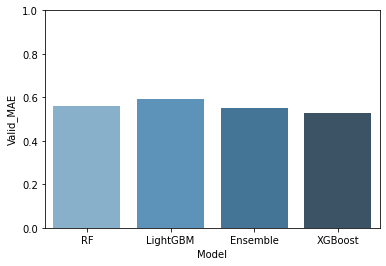

In [64]:
mae_valid = [mae_va_rf, mae_va_lgb, mae_va_en, mae_va_xgb]
recap_model = ['RF', 'LightGBM', 'Ensemble','XGBoost']
df_recap = pd.DataFrame({'Model': recap_model, 'Valid_MAE' : mae_valid})
ax = sns.barplot(x='Model', y='Valid_MAE', data=df_recap, palette="Blues_d")
ax.set_ylim([0.0, 1.0]) 

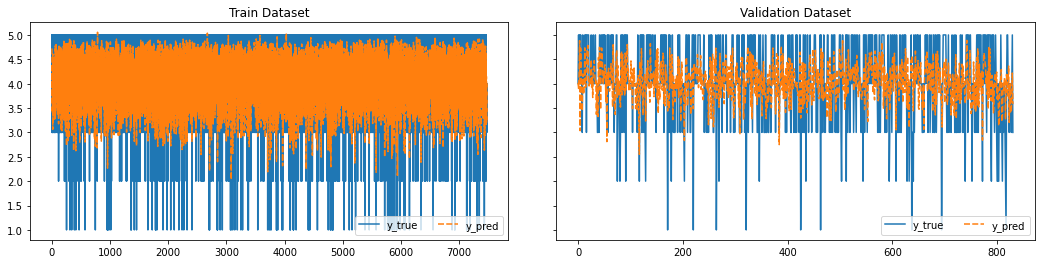

<Figure size 432x288 with 0 Axes>

In [ ]:
df_train = pd.DataFrame({'y_true': y_train.values, 'y_pred': y_pred_tr_en})
df_valid = pd.DataFrame({'y_true': y_valid.values, 'y_pred': y_pred_va_en})

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18,4))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.lineplot(data = df_train, ax=axes[0])
sns.lineplot(data = df_valid, ax=axes[1])

axes[0].set_title('Train Dataset')
axes[1].set_title('Validation Dataset')

axes[0].legend(loc='lower right', ncol=2)
axes[1].legend(loc='lower right', ncol=2)

plt.show()
plt.clf() 

이렇게 해서는 데이터량이 많아서 잘 안보임.
1000개씩 쪼개서 Validation 결과만 살펴보면 아래와 같이 확대해서 볼 수 있음.

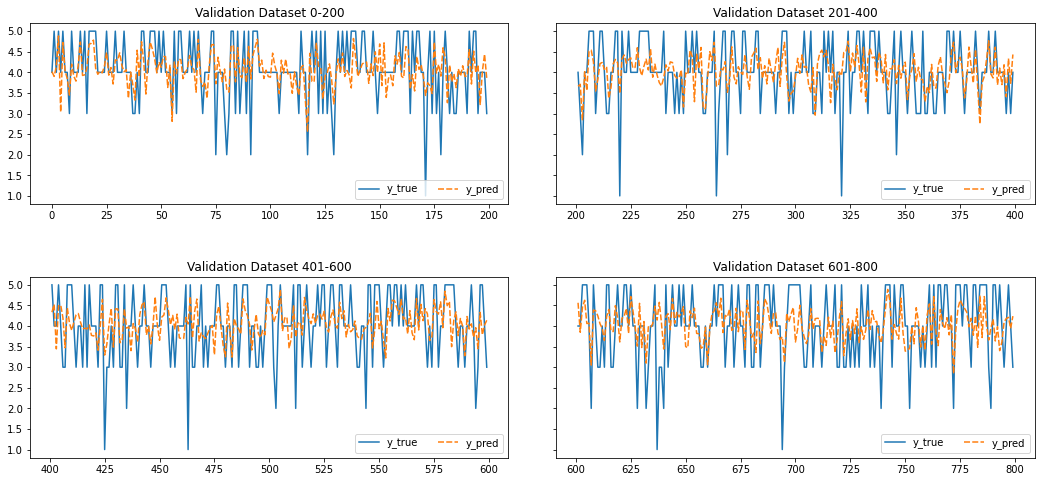

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(18,4*2))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.lineplot(data = df_valid[0:200], ax=axes[0][0])
sns.lineplot(data = df_valid[201:400], ax=axes[0][1])
sns.lineplot(data = df_valid[401:600], ax=axes[1][0])
sns.lineplot(data = df_valid[601:800], ax=axes[1][1])


axes[0][0].set_title('Validation Dataset 0-200')
axes[0][1].set_title('Validation Dataset 201-400')
axes[1][0].set_title('Validation Dataset 401-600')
axes[1][1].set_title('Validation Dataset 601-800')

for i in range(2):
  axes[i][0].legend(loc='lower right', ncol=2)
  axes[i][1].legend(loc='lower right', ncol=2)

plt.show()
plt.clf() 

## 6. Submission

### 6.1. 데이터 정수화 및 이상치 확인

정수화 하고 나서 5보다 큰 값이 있는지? 1보다 작은 값이 있는지? 확인.

In [49]:
for n in np.around(y_pred_te_en):
  if n > 5:
    print(n)
  elif n < 1:
    print(n)

In [50]:
for n in np.around(y_pred_te_xgb):
  if n > 5:
    print(n)
  elif n < 1:
    print(n)

이상없음.

### 6.2. submission format 에 데이터 입력

In [65]:
submit['총평'] = list(np.around(y_pred_te_en))

In [66]:
submit['총평'].describe()

count    711.000000
mean       4.122363
std        0.541717
min        3.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: 총평, dtype: float64

In [67]:
submit['총평'] = list(np.around(y_pred_te_xgb))

In [68]:
submit['총평'].describe()

count    711.000000
mean       4.157525
std        0.569602
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: 총평, dtype: float64

### 6.3. 파일명에 날짜/시간정보 기입

In [70]:
now = datetime.datetime.now()
submit.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)